In [1]:
import pandas as pd
import scipy as sp
import numpy as np
import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sb
import sklearn as sk
#import torch

## Read and Clean Data
The dataset is clean and consistently formatted, but I still perform validation and coercion as a best practice.

In [2]:
# Load CSV
df = pd.read_csv(
    'price_data_multicurrency.csv',
    encoding='utf-8',
    on_bad_lines='skip',
    engine='python'
)

# Standardize column names
df.columns = df.columns.str.strip().str.upper()

# Convert price to numeric
df['PRICE'] = pd.to_numeric(df['PRICE'], errors='coerce')

# Clean currency text
df['CURRENCY'] = df['CURRENCY'].astype(str).str.upper().str.strip()

# Convert timestamp
df['TRADE_TIMESTAMP'] = pd.to_datetime(df['TRADE_TIMESTAMP'], errors='coerce')

# Remove any improper cases
df = df.dropna(subset=['PRICE', 'CURRENCY', 'TRADE_TIMESTAMP'])
df = df[df['CURRENCY'].isin(['EUR', 'AUD', 'USD'])]

# Sort by timestamp
df = df.sort_values('TRADE_TIMESTAMP').reset_index(drop=True)

# Display the cleaned dataset summary
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 815 entries, 0 to 814
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   TRADE_TIMESTAMP  815 non-null    datetime64[ns]
 1   PRICE            815 non-null    float64       
 2   CURRENCY         815 non-null    object        
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 19.2+ KB


## Data Exploration
Currencies have distinct price distributions, volatility profiles, and behavioral patterns. We will explore the dataset to understand the distribution of prices, timestamps, and currency labels. This will help us verify data quality and identify any patterns that will be useful for feature engineering.

In [3]:
df.head()

,TRADE_TIMESTAMP,PRICE,CURRENCY
0,2018-01-02 22:28:01.747,0.0938,EUR
1,2018-01-03 02:17:53.896,0.0876,EUR
2,2018-01-03 09:57:12.584,0.0802,AUD
3,2018-01-03 22:09:31.159,0.0692,EUR
4,2018-01-04 02:22:08.771,0.0675,EUR


In [4]:
df.describe(include='all')

,TRADE_TIMESTAMP,PRICE,CURRENCY
count,815,815.000000,815
unique,NaN,NaN,3
top,NaN,NaN,EUR
freq,NaN,NaN,423
mean,2018-06-06 21:34:12.245659136,0.065127,NaN
min,2018-01-02 22:28:01.747000,0.033000,NaN
25%,2018-03-23 12:28:55.644499968,0.057750,NaN
50%,2018-06-12 22:38:35.164999936,0.064500,NaN
75%,2018-08-19 23:17:07.388000256,0.072700,NaN
max,2018-10-30 22:50:36.370000,0.093800,NaN


In [5]:
df['CURRENCY'].value_counts()

,count
CURRENCY,
EUR,423
AUD,269
USD,123


**Price Distribution by Currency-**

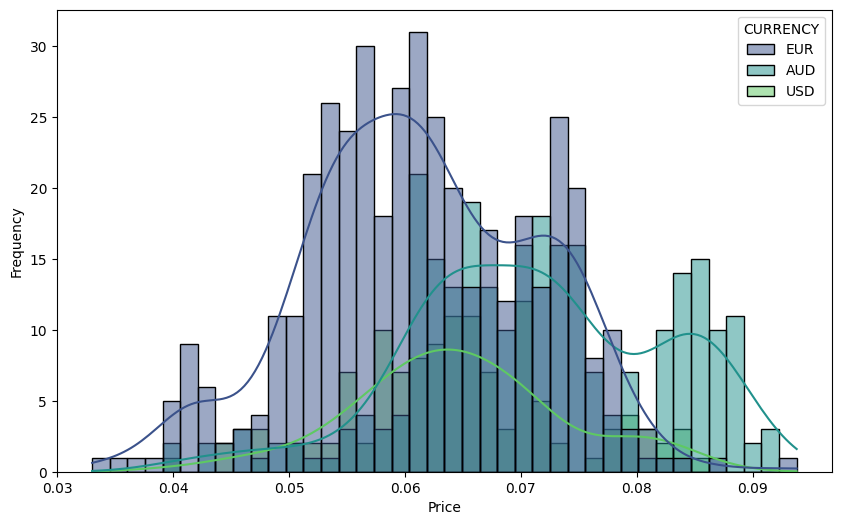

In [6]:
plt.figure(figsize=(10,6))
sb.histplot(data=df, x='PRICE', hue='CURRENCY', kde=True, bins=40, palette='viridis')
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.show()

Clear differences in the central ranges and density shapes:

AUD - highest overall price levels, prices in the 0.08–0.09 range are predominantly AUD

EUR - prices cluster more tightly around 0.055–0.065, highest density of observations

USD - occupies a central band (around 0.06–0.07) but with lower density

/tmp/ipython-input-853024167.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.boxplot(data=df, x='CURRENCY', y='PRICE', palette='deep')


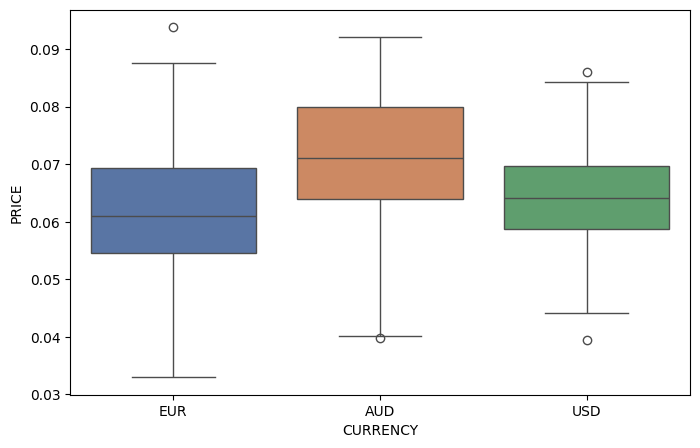

In [7]:
plt.figure(figsize=(8,5))
sb.boxplot(data=df, x='CURRENCY', y='PRICE', palette='deep')
plt.show()

AUD has the highest median price and the highest upper quartile.

EUR has several noticeable downward outliers.

USD shows a moderate range between EUR and AUD.

**Price Movements Over Time-**

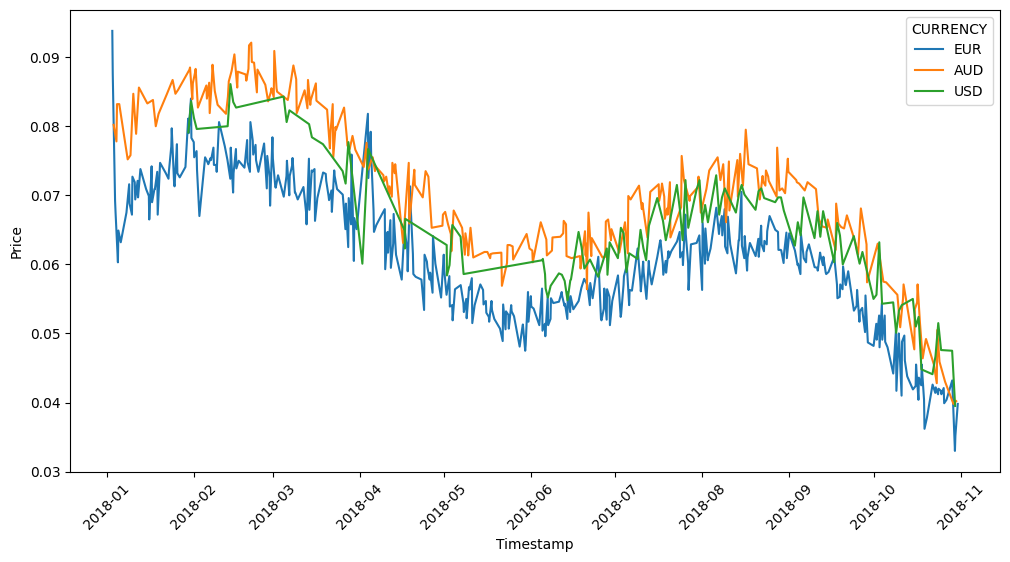

In [8]:
plt.figure(figsize=(12,6))
sb.lineplot(data=df, x='TRADE_TIMESTAMP', y='PRICE', hue='CURRENCY')
plt.xlabel("Timestamp")
plt.ylabel("Price")
plt.xticks(rotation=45)
plt.show()

Although the currencies follow a similar long-term trend, they maintain consistent separation in their price levels over time.

The relative ordering (AUD > USD > EUR) is stable throughout the year.

**Volatility Analysis-**

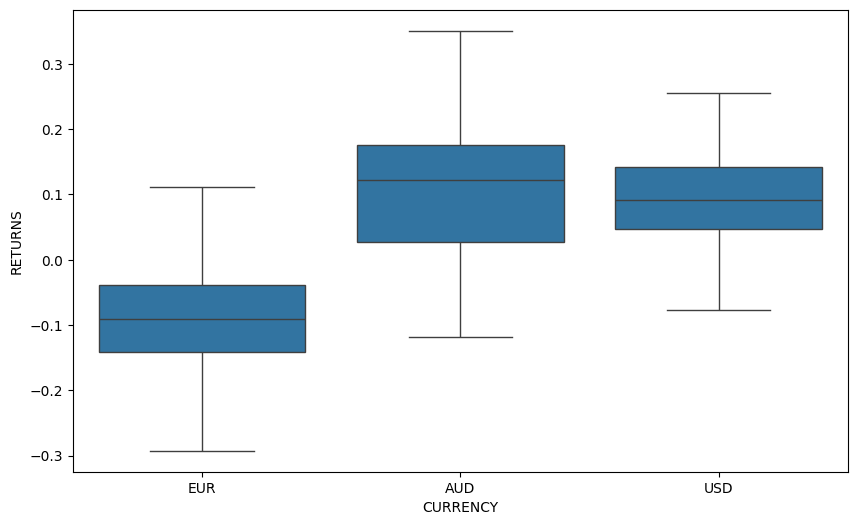

In [9]:
df['RETURNS'] = df['PRICE'].pct_change()

plt.figure(figsize=(10,6))
sb.boxplot(x='CURRENCY', y='RETURNS', data=df, showfliers=False)
plt.show()

The return distributions highlight differences in short-term price movements:

AUD has the largest return variability, with higher positive swings and a wider overall range.

EUR has the most negative median returns and the least variability.

USD falls between the two, with moderate volatility.

**Correlation Heatmap-**

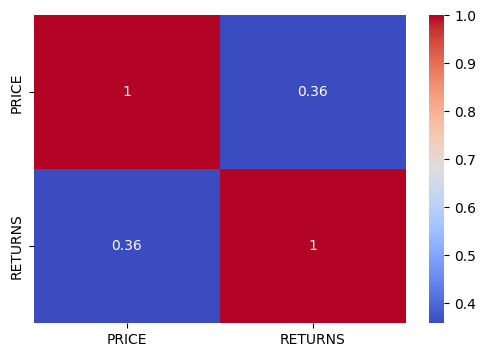

In [10]:
plt.figure(figsize=(6,4))
sb.heatmap(df[['PRICE','RETURNS']].corr(), annot=True, cmap='coolwarm')
plt.show()

A moderate positive correlation (0.36) between PRICE and RETURNS, indicating that higher prices slightly coincide with larger returns.

**Time-Based Analysis-**

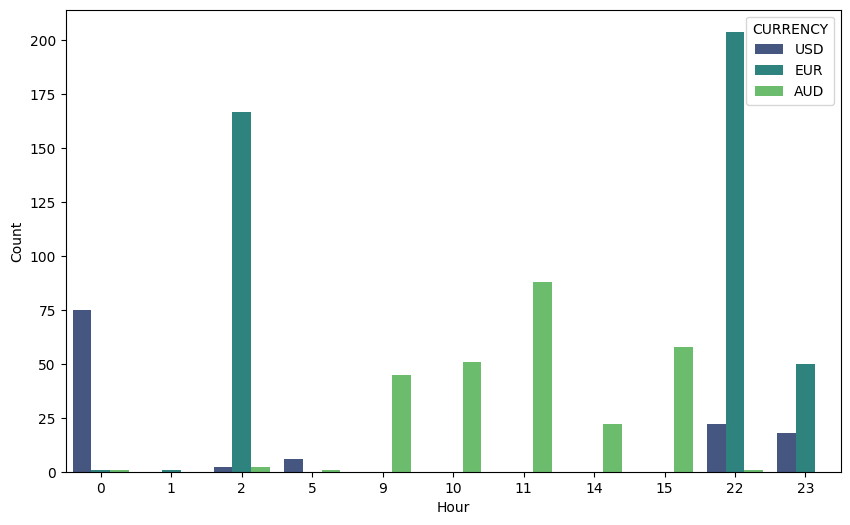

In [11]:
df['HOUR'] = df['TRADE_TIMESTAMP'].dt.hour

plt.figure(figsize=(10,6))
sb.countplot(data=df, x='HOUR', hue='CURRENCY', palette='viridis')
plt.xlabel("Hour")
plt.ylabel("Count")
plt.show()


Each currency tends to appear during specific hours of the day.

USD dominates the early-day hour (0)

EUR dominates very early morning (2) and late night (22–23)

AUD dominates mid-day hours (9–15)

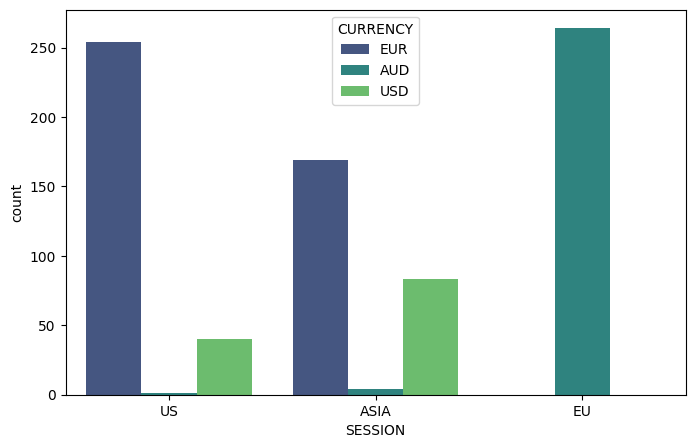

In [12]:
def session_from_hour(h):
    if 0 <= h < 8:
        return 'ASIA'
    elif 8 <= h < 16:
        return 'EU'
    else:
        return 'US'

df['SESSION'] = df['HOUR'].apply(session_from_hour)

plt.figure(figsize=(8,5))
sb.countplot(data=df, x='SESSION', hue='CURRENCY', palette='viridis')
plt.show()

EUR is dominant in the US & Asia sessions (unexpected)

AUD is massively dominant in the EU session

USD appears mainly in US + Asia

## Feature Engineering-

In [13]:
# Log Returns
df['LOG_RETURN'] = np.log(df['PRICE']).diff()

# Normalize Prices (Z-score)
df['PRICE_Z'] = (df['PRICE'] - df['PRICE'].mean()) / df['PRICE'].std()

# Extract Day of Week for Time-Based Features
df['DAY_OF_WEEK'] = df['TRADE_TIMESTAMP'].dt.dayofweek

# Encode session into numeric indicator variables
df = pd.get_dummies(df, columns=['SESSION'], prefix='SESSION')

# Clean Up NaNs Caused by Rolling Windows
df = df.dropna().reset_index(drop=True)

## Model Training-

In [14]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

In [15]:
# Label
y = df['CURRENCY']

# Feature columns
feature_cols = [
    'PRICE', 'PRICE_Z',
    'RETURNS', 'LOG_RETURN',
    'HOUR', 'DAY_OF_WEEK',
    'SESSION_ASIA', 'SESSION_EU', 'SESSION_US'
]

X = df[feature_cols]

#Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

I experimented with artificially balancing the evaluation set by selecting an equal number of examples from each currency. This reduced overall accuracy from ~98.7% to ~93%, showing that the classifier performs best when trained and tested on the natural distribution of currencies. Because the true market structure is uneven by nature, oversampling would distort price and time-of-day patterns.

**Gradient Boosting** is the best model for structured tabular datasets like this one. It handles price levels, volatility patterns, and time features extremely well without overfitting. Deep learning is unnecessary here because we classify each quote independently rather than predicting sequences.

In [16]:
# Train Gradient Boosting Classifier
model = GradientBoostingClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=2,
    random_state=42
)

model.fit(X_train, y_train)

# Evaluate Model Accuracy
y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.9877300613496932
              precision    recall  f1-score   support

         AUD       1.00      0.98      0.99        54
         EUR       0.99      1.00      0.99        84
         USD       0.96      0.96      0.96        25

    accuracy                           0.99       163
   macro avg       0.98      0.98      0.98       163
weighted avg       0.99      0.99      0.99       163



The classifier is extremely accurate, but when it does make mistakes, it tends to incorrectly label AUD or USD as EUR. The model is most accurate on EUR, then AUD, and slightly less accurate on USD. EUR is very easy for the model to detect because it has the tightest price cluster, strong time-of-day patterns, and the largest number of examples. USD is the hardest to classify because there is less training data and its price levels overlap more heavily with both EUR and AUD.

## Evaluation-

**Confusion Matrix-**

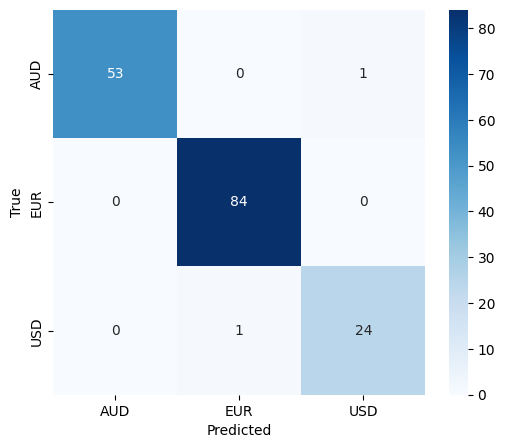

In [17]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred, labels=model.classes_)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=model.classes_,
            yticklabels=model.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

**Probability Confidence-**

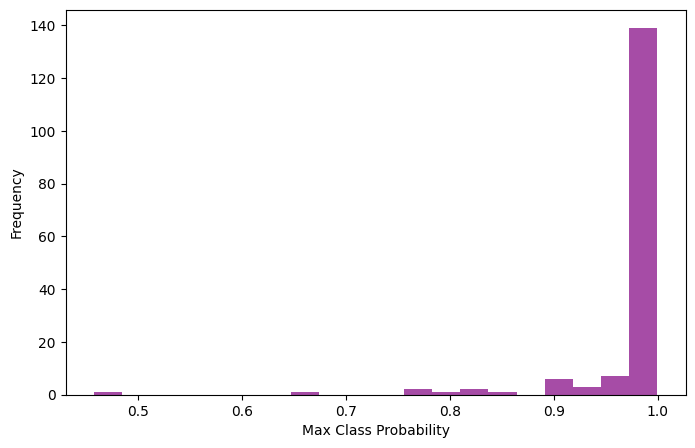

In [18]:
probs = model.predict_proba(X_test).max(axis=1)

plt.figure(figsize=(8,5))
plt.hist(probs, bins=20, color='purple', alpha=0.7)
plt.xlabel("Max Class Probability")
plt.ylabel("Frequency")
plt.show()

**Feature Importance Plot-**

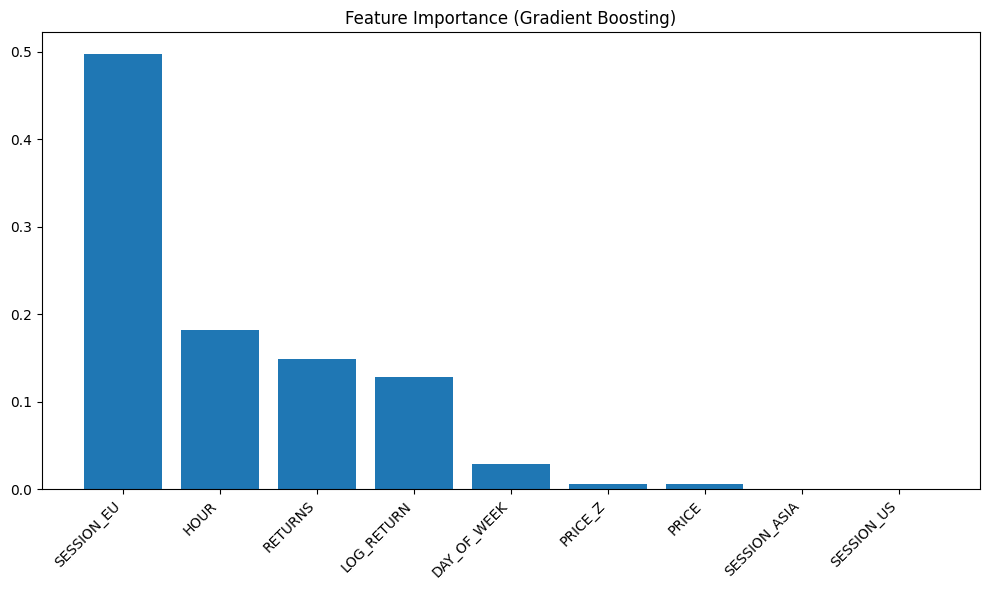

In [19]:
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
names = [feature_cols[i] for i in indices]

plt.figure(figsize=(10,6))
plt.title("Feature Importance (Gradient Boosting)")
plt.bar(range(len(importances)), importances[indices])
plt.xticks(range(len(importances)), names, rotation=45, ha='right')
plt.tight_layout()
plt.show()

**Hyperparameters-**

In [20]:
results = []

for n in [150, 300, 500]:
    for lr in [0.1, 0.05, 0.02]:
        for depth in [2, 3, 4]:

            model_tuned = GradientBoostingClassifier(
                n_estimators=n,
                learning_rate=lr,
                max_depth=depth,
                random_state=42
            )

            model_tuned.fit(X_train, y_train)
            preds = model_tuned.predict(X_test)

            acc = accuracy_score(y_test, preds)
            results.append((n, lr, depth, acc))

tuning_df = pd.DataFrame(results, columns=['Trees', 'Learning Rate', 'Depth', 'Accuracy'])
tuning_df.sort_values('Accuracy', ascending=False)

,Trees,Learning Rate,Depth,Accuracy
12,300,0.05,2,0.987730
4,150,0.05,3,0.981595
0,150,0.10,2,0.981595
9,300,0.10,2,0.981595
24,500,0.02,2,0.981595
16,300,0.02,3,0.981595
3,150,0.05,2,0.981595
8,150,0.02,4,0.975460
1,150,0.10,3,0.975460
2,150,0.10,4,0.975460


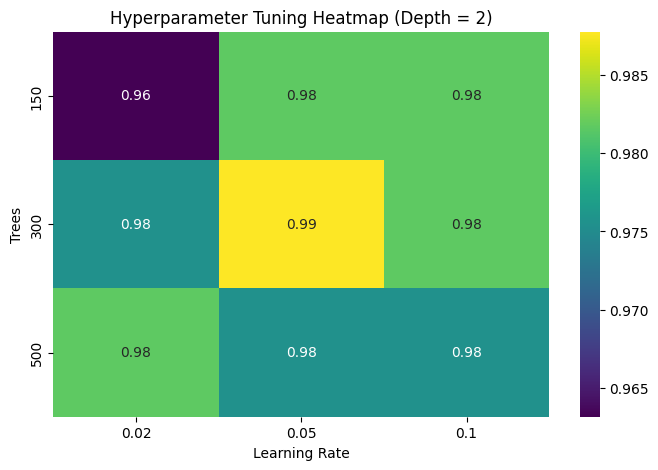

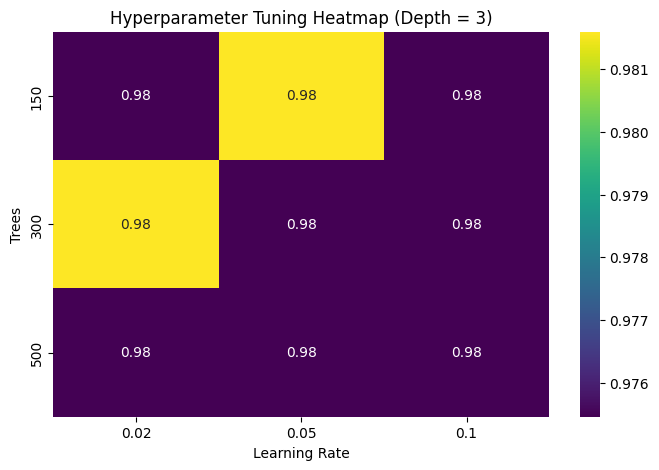

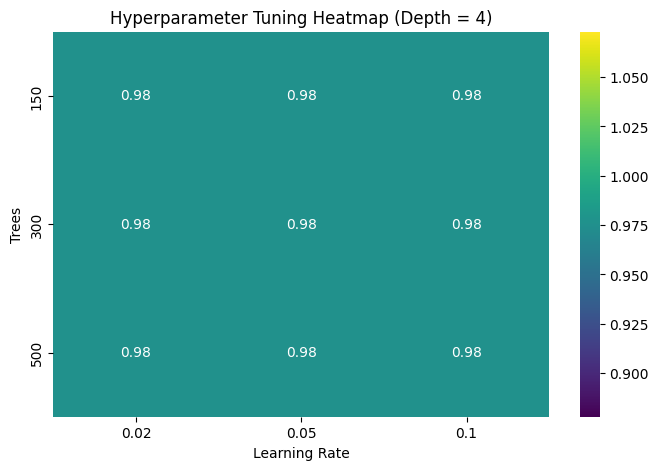

In [21]:
depth_levels = tuning_df['Depth'].unique()

for depth in depth_levels:
    subset = tuning_df[tuning_df['Depth'] == depth]

    pivot = subset.pivot_table(
        values='Accuracy',
        index='Trees',
        columns='Learning Rate'
    )

    plt.figure(figsize=(8,5))
    sns.heatmap(pivot, annot=True, cmap='viridis', fmt=".2f")
    plt.title(f"Hyperparameter Tuning Heatmap (Depth = {depth})")
    plt.xlabel("Learning Rate")
    plt.ylabel("Trees")
    plt.show()

The model's optimal performance region appears around 300 trees and a 0.05 learning rate at a depth of 2, which achieves ~99% accuracy, so I reconfigured my model to reflect these hyperparameters.

## Prediction Function-

In [22]:
# Predict the currency for a new quote based on price and timestamp.
# Returns (predicted_currency, probability).

def predict_currency(price, timestamp):
    # Convert timestamp
    ts = pd.to_datetime(timestamp)

    # Build feature row
    row = {}
    row['PRICE'] = price
    row['PRICE_Z'] = (price - df['PRICE'].mean()) / df['PRICE'].std()

    row['RETURNS'] = 0
    row['LOG_RETURN'] = 0

    row['HOUR'] = ts.hour
    row['DAY_OF_WEEK'] = ts.dayofweek
    row['SESSION_ASIA'] = 1 if 0 <= ts.hour < 8 else 0
    row['SESSION_EU']   = 1 if 8 <= ts.hour < 16 else 0
    row['SESSION_US']   = 1 if ts.hour >= 16 else 0

    # Convert to DataFrame
    row_df = pd.DataFrame([row])[feature_cols]

    # Predict
    probs = model.predict_proba(row_df)[0]
    prediction = np.argmax(probs)

    return model.classes_[prediction], round(probs[prediction], 4)

**Test Function-**

In [23]:
# AUD-like price (high price + AUD trading hour)
predict_currency(0.088, "2018-05-03 10:30:00")

('AUD', np.float64(0.9994))

In [24]:
# EUR-like price (tight 0.055–0.065 range + EUR hour)
predict_currency(0.060, "2018-07-19 02:45:00")

('EUR', np.float64(0.9689))

At first, this returned AUD, even though EUR was supposed to be fully accurate, so I realized I had trained the model on rolling volatility and rolling means, which isn't compatible with a single input, so I removed that from the features and retested. This initially resulted in lower accuracy, so after evaluating the hyperparameter tuning tests, i restructured the model and achieved high accuracy again.

In [25]:
# USD-like time (middle price, late US hours)
predict_currency(0.065, "2018-06-12 23:10:00")

('USD', np.float64(0.744))

In [26]:
# Run whole test set through prediction function
correct = 0
total = len(X_test)

results = []

for i, row in X_test.iterrows():
    true_label = y_test.loc[i]
    price = df.loc[i, 'PRICE']
    timestamp = df.loc[i, 'TRADE_TIMESTAMP']

    pred_label, prob = predict_currency(price, timestamp)

    # Count correctness
    if pred_label == true_label:
        correct += 1

    # Store row-by-row data if you want to inspect later
    results.append({
        'true': true_label,
        'pred': pred_label,
        'prob': prob,
        'price': price,
        'timestamp': timestamp
    })

# Convert to DataFrame
results_df = pd.DataFrame(results)

# Accuracy
accuracy = correct / total
print(f"Custom Function Accuracy on Test Set: {accuracy:.4f}")

for currency in ['EUR', 'AUD', 'USD']:
    subset = results_df[results_df['true'] == currency]
    acc = (subset['true'] == subset['pred']).mean()
    print(f"{currency} accuracy: {acc:.4f} ({len(subset)} samples)")


Custom Function Accuracy on Test Set: 0.9755
EUR accuracy: 0.9881 (84 samples)
AUD accuracy: 0.9815 (54 samples)
USD accuracy: 0.9200 (25 samples)
